In [1]:
#############################################Ethan L. Mines##############################
#############################################VandyHacks IV: October 20-22###############
import numpy as np
import cntk as C

####################################Hyperparameters#####################################
numType = np.float32
num_layers = 1
learning_rate = 0.1
training_ratio = 3 / 4
learnerFunction = C.sgd
mb_size = 25

dataDir = "../Dataset/"
outputDir = ""

np.random.seed(0)
C.cntk_py.set_fixed_random_seed(0)

In [2]:
def shuffle_arrays(*arrays):
    rand_state = np.random.get_state()
    for array in arrays:
        np.random.set_state(rand_state)
        np.random.shuffle(array)

###############shuffle_arrays debug#################
"""
a = np.asarray([24, 86, 98, 45, 22])
b = np.asarray([36, 79, 7, 11, 52])
c = np.asarray([26, 78, 99, 40, 25])

shuffle_arrays(a, b, c)
print(a)
print(b)
print(c)
"""

'\na = np.asarray([24, 86, 98, 45, 22])\nb = np.asarray([36, 79, 7, 11, 52])\nc = np.asarray([26, 78, 99, 40, 25])\n\nshuffle_arrays(a, b, c)\nprint(a)\nprint(b)\nprint(c)\n'

In [3]:
def classifier(output_dim, input_var, num_layers):
    z = C.layers.Dense(output_dim)(input_var)
    for i in range(num_layers - 1):
        z = C.layers.Dense(output_dim)(z)
    return z

In [4]:
def my_trainer(z, labels):    
    lr_schedule = C.learning_rate_schedule(learning_rate, C.UnitType.minibatch)
    learner = learnerFunction(z.parameters, lr_schedule)
    loss = C.cross_entropy_with_softmax(z, labels)
    eval_error = C.classification_error(z, labels)
    trainer = C.Trainer(z, (loss, eval_error), [learner])
    return trainer

In [5]:
#######################Modified from Microsoft CNTK101 Tutorial#####################
def print_progress(trainer, mb_num, frequency, display = True):
    loss, eval_error = "NA", "NA"
    if mb_num % frequency == 0:
        loss = trainer.previous_minibatch_loss_average
        eval_error = trainer.previous_minibatch_evaluation_average
        if display:
            i = 0
            #print("Minibatch {0:04n}: Average Loss = {1:.4f}, Average Error = {2:.4f}".format(mb_num, loss, eval_error))
    return mb_num, loss, eval_error

In [6]:
###########################Modified from Microsoft CNTK101 Tutorial#################
from collections import defaultdict

def train_model(trainer, training_size, mb_size, features, labels, input_var, label_var):
    training_plotdata = defaultdict(list)
    progress_output_freq = 50
    training_features = features[:training_size]
    training_labels = labels[:training_size]
    
    num_training_mbs = training_size // mb_size
    
    for i in range(num_training_mbs):
        start_index = i * mb_size
        end_index = start_index + mb_size
        feature_batch = training_features[start_index : end_index]
        label_batch = training_labels[start_index : end_index]
        trainer.train_minibatch({input_var : feature_batch, label_var : label_batch})
    
        mb_num, loss, error = print_progress(trainer, i, progress_output_freq)
        if loss != "NA":
            training_plotdata["Batch Number"].append(mb_num)
            training_plotdata["Loss"].append(loss)
            training_plotdata["Error"].append(error)
            
    return training_plotdata

def test_model(trainer, training_size, mb_size, features, labels, input_var, label_var):
    testing_plotdata = defaultdict(list)
    testing_features = features[training_size:]
    testing_labels = labels[training_size:]
    
    num_testing_mbs = (len(features) - training_size) // mb_size
    for i in range(num_testing_mbs):
        start_index = i * mb_size
        end_index = start_index + mb_size
        feature_batch = testing_features[start_index : end_index]
        label_batch = testing_labels[start_index : end_index]
    
        eval_error = trainer.test_minibatch({input_var : feature_batch, label_var : label_batch})
    
        if eval_error != "NA":
            testing_plotdata["Batch Number"].append(i)
            testing_plotdata["Error"].append(eval_error)
            
    return testing_plotdata

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

def graphResults(training_plotdata, testing_plotdata):

    training_plotdata["Average Loss"] = moving_average(training_plotdata["Loss"])
    training_plotdata["Average Error"] = moving_average(training_plotdata["Error"])
    testing_plotdata["Average Error"] = moving_average(testing_plotdata["Error"])

    plt.plot(training_plotdata["Batch Number"], training_plotdata["Average Loss"])
    plt.title("Training Loss")
    plt.xlabel("Minibatch Number")
    plt.ylabel("Cumulative Average Loss")
    plt.show()
    print("Average Training Loss = {0:.2f}".format(training_plotdata["Average Loss"][-1]))
    
    plt.plot(training_plotdata["Batch Number"], training_plotdata["Average Error"])
    plt.title("Training Error")
    plt.xlabel("Minibatch Number")
    plt.ylabel("Cumulative Average Error")
    plt.show()
    print("Average Training Error = {0:.2f}".format(training_plotdata["Average Error"][-1]))
    

    plt.hist(testing_plotdata["Error"])
    plt.title("Testing Error")
    plt.xlabel("Minibatch Average Error")
    plt.ylabel("Frequency")
    plt.show()    
    print("Average Testing Error = {0:.2f}".format(testing_plotdata["Average Error"][-1]))

In [8]:
def moving_average(loss_list):
    averages = np.cumsum(np.asarray(loss_list))
    for i in range(len(averages)):
        averages[i] = averages[i] / (i + 1)
    return averages

#Expects number of possible categories "num_categories" and category index "category" in range 0...num_categories-1
def toOneHot(column, indexDict):
    #print(len(column), ",", len(indexDict))
    oneHot = np.zeros( (len(column), len(indexDict)), dtype = numType)
    
    for i in range(len(column)):
        oneHot[i][ indexDict[column[i]] ] = 1
    
    #print(oneHot[:5])
    return oneHot

#############Returns str->int dictionary where the int's are indices for one-hot vectors of categories in column
def extractCategories(column, categPath):
    dictionary = {}
    i = 0
    with open(categPath, "w") as categDict:
        for element in column:
            if element not in dictionary:
                dictionary[element] = i
                i += 1
                categDict.write(element + "\n")
    return dictionary

#One-hot encodes all the CSV data
#Also writes simple text files that can than be used to reconstruct the index dictionaries
def process_csv(source, prefix):
    data = np.genfromtxt(dataDir + source, delimiter = ",", dtype = str)
    
    debug_limit = 15
    
    """
    print(data[:debug_limit])
    print()
    """
    
    column_indices = {"month": 1,
                     "hour": 2,
                     "weekday": 3,
                     "zip_code": 4,
                     "crime": 7
                     }
    
    months = data[:, column_indices["month"]]
    hours = data[:, column_indices["hour"]]
    weekdays = data[:, column_indices["weekday"]]
    zips = data[:, column_indices["zip_code"]]
    crimes = data[:, column_indices["crime"]]

    """  
    fields = [months, hours, weekdays, zips, crimes]
    for field in fields:
        print(field[:debug_limit])
    print()
    """
    
    monthsDict = extractCategories(months, outputDir + prefix + "_month_dict")
    hoursDict = extractCategories(hours, outputDir + prefix + "_hours_dict")
    weekdaysDict = extractCategories(weekdays, outputDir + prefix + "_weekdays_dict")
    zipsDict = extractCategories(zips, outputDir + prefix + "_zips_dict")
    crimesDict = extractCategories(crimes, outputDir + prefix + "_crimes_dict")
    
    """
    dicts = [monthsDict, hoursDict, weekdaysDict, zipsDict, crimesDict]
    for dictionary in dicts:
        print(dictionary)
    print()
    """

    months = toOneHot(months, monthsDict)
    hours = toOneHot(hours, hoursDict)
    weekdays = toOneHot(weekdays, weekdaysDict)
    zips = toOneHot(zips, zipsDict)
    crimes = toOneHot(crimes, crimesDict)
    
    """
    fields = [months, hours, weekdays, zips, crimes]
    for field in fields:
        print(field[:debug_limit])
    print()
    """
    

    shuffle_arrays(months, hours, weekdays, zips, crimes)
    features = np.column_stack((months, hours, weekdays))
    
    #print(features[:debug_limit])
    
    return features, zips, crimes

In [9]:
def gen_models(source, prefix):

    features, zips, crimes = process_csv(source, prefix)
    
    #print(features[:5])
    #print(len(features[0]))
    num_features = len(features[0])
    num_zips = len(zips[0])
    num_crimes = len(crimes[0])
    

    #Model variables
    input = C.input_variable(num_features, dtype = numType)    
    zip_label = C.input_variable(num_zips, dtype = numType)
    crime_label = C.input_variable(num_crimes, dtype = numType)

    #print(zip_label.shape)
    #print(crime_label.shape)
    
    
    #Actual models
    zone_classifier = classifier(zip_label.shape[0], input, num_layers)
    crime_classifier = classifier(crime_label.shape[0], input, num_layers)
    
    
    
    zip_trainer = my_trainer(zone_classifier, zip_label)
    crime_trainer = my_trainer(crime_classifier, crime_label)

    num_samples = len(zips)
    num_training = int(num_samples * training_ratio)
    
    #print(num_samples)
    #print(num_training)

    print("ZIP CODE MODEL")
    zip_train_results = train_model(zip_trainer, num_training, mb_size, features, zips, input, zip_label)    
    zip_test_results = test_model(zip_trainer, num_training, mb_size, features, zips, input, zip_label)
    graphResults(zip_train_results, zip_test_results)
    print()

    print("CRIME TYPE MODEL")
    crime_train_results = train_model(crime_trainer, num_training, mb_size, features, crimes, input, crime_label)
    crime_test_results = test_model(crime_trainer, num_training, mb_size, features, crimes, input, crime_label)
    graphResults(crime_train_results, crime_test_results)
    
    return zone_classifier, crime_classifier

In [10]:
def write_parameters(model, suffix):
    weights = model.parameters[0].value
    biases = model.parameters[1].value
    
    path = outputDir + suffix + ".param"
    
    #print(weights)
    
    with open(path, "w") as parameters:
        for row in weights:
            for weight in row:
                strVer = "{}".format(weight)
                #print(strVer)
                parameters.write(strVer)
                parameters.write("\n")
                
        for bias in biases:
            strVer = "{}".format(bias)
            parameters.write(strVer)
            parameters.write("\n")
                
    print(path, "written.")
    

def write_model_files(source, prefix):

    save_as_cmf = 0
    
    zone_model, crime_model = gen_models(source, prefix)
    
    print()

    
    if save_as_cmf:
        zone_model_path = outputDir + prefix + "_zips.cmf"
        crime_model_path = outputDir + prefix + "_crimes.cmf"
        zone_model.save(zone_model_path)
        print("Wrote " + zone_model_path)
        crime_model.save(crime_model_path)
        print("Wrote " + crime_model_path)
    else:
        write_parameters(zone_model, "zips")
        write_parameters(crime_model, "crimes")
    


ZIP CODE MODEL


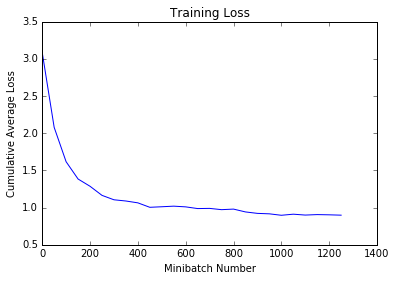

Average Training Loss = 0.90


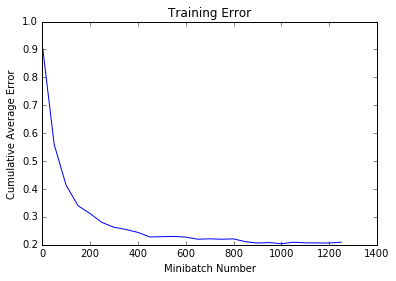

Average Training Error = 0.21


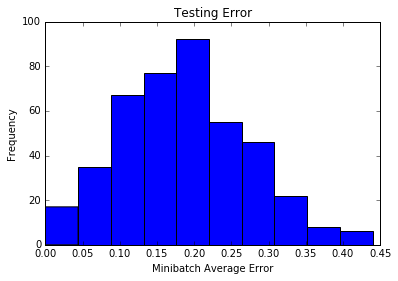

Average Testing Error = 0.19

CRIME TYPE MODEL


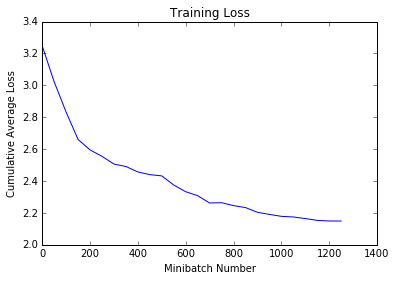

Average Training Loss = 2.15


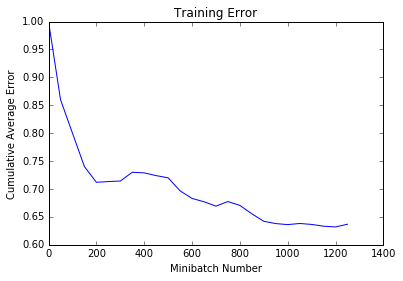

Average Training Error = 0.64


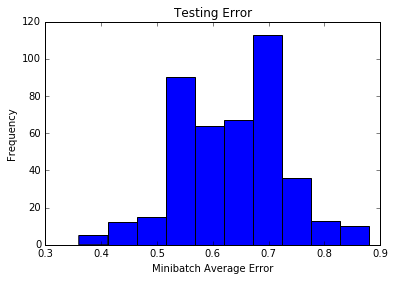

Average Testing Error = 0.63

zips.param written.
crimes.param written.


In [22]:
datafiles = ["cleanedArizona.csv"]
model_prefixes =["arizona"] # For naming saved model files

for i in range(len(datafiles)):
    write_model_files(datafiles[i], model_prefixes[i])

## Heading